# 3.1 线性回归

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
# 矢量化加速：在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。 
# 为了实现这一点，需要我们对计算进行矢量化，从而利用线性代数库，
# 而不是在Python中编写开销高昂的for循环。
n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
# 定义计时器
# 类实例化后，self即代表着实例（对象）本身
class Timer: #@save
    '''记录多次运行时间'''
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        '''启动计时器'''
        self.tik = time.time()
    
    def stop(self):
        '''停止计时器并将时间记录在列表中'''
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        '''返回平均时间'''
        return sum(self.times) / len(self.times)
    
    def sum(self):
        '''返回时间总和'''
        return sum(self.times)
    
    def cumsum(self):
        '''返回累计时间'''
        return np.array(self.times).cumsum().tolist()

In [4]:
# 加速效果
# for 循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.00500 sec'

In [5]:
# 向量运算 矢量化代码通常会带来数量级的加速
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [6]:
# 正态分布与平方误差，线性回归最优解的统计学解释
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2) 

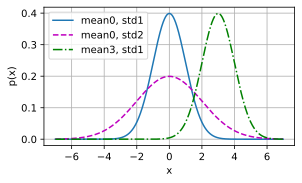

In [7]:
# 使用python进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
# 画图也有类似的广播机制
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', 
        ylabel='p(x)', figsize=(4.5, 2.5), 
        legend=[f'mean{mu}, std{sigma}' for mu, sigma in params])

In [8]:
timer.times

[0.004999637603759766, 0.0]

In [9]:
# 小结 
# 机器学习模型中的关键要素是训练数据、损失函数、优化算法，还有模型本身
# 矢量化使数学表达上更简洁，同时运行的更快
# 最小化目标函数和执行极大似然估计等价
# 线性回归模型也是一个简单的神经网络

# 3.2 线性回归从零开始实现

In [10]:
import random

## 3.2.1 生成数据集

In [11]:
def synthetic_data(w, b, num_examples): #@save
    '''生成y=Xw+b+噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b 
    # 噪声
    y += torch.normal(0, 0.1, y.shape)
    return X, y.reshape(-1, 1)

#声明张量数据类型
true_w = torch.tensor([2, -3.4], dtype=torch.float32)
true_b = 4.2
# features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.5970, -0.1370]) 
label: tensor([3.2773])


In [12]:
help(torch.normal)

Help on built-in function normal in module torch:

normal(...)
    normal(mean, std, *, generator=None, out=None) -> Tensor
    
    Returns a tensor of random numbers drawn from separate normal distributions
    whose mean and standard deviation are given.
    
    The :attr:`mean` is a tensor with the mean of
    each output element's normal distribution
    
    The :attr:`std` is a tensor with the standard deviation of
    each output element's normal distribution
    
    The shapes of :attr:`mean` and :attr:`std` don't need to match, but the
    total number of elements in each tensor need to be the same.
    
    .. note:: When the shapes do not match, the shape of :attr:`mean`
              is used as the shape for the returned output tensor
    
    .. note:: When :attr:`std` is a CUDA tensor, this function synchronizes
              its device with the CPU.
    
    Args:
        mean (Tensor): the tensor of per-element means
        std (Tensor): the tensor of per-element st

In [13]:
# 常数不算维度
help(torch.matmul)

Help on built-in function matmul in module torch:

matmul(...)
    matmul(input, other, *, out=None) -> Tensor
    
    Matrix product of two tensors.
    
    The behavior depends on the dimensionality of the tensors as follows:
    
    - If both tensors are 1-dimensional, the dot product (scalar) is returned.
    - If both arguments are 2-dimensional, the matrix-matrix product is returned.
    - If the first argument is 1-dimensional and the second argument is 2-dimensional,
      a 1 is prepended to its dimension for the purpose of the matrix multiply.
      After the matrix multiply, the prepended dimension is removed.
    - If the first argument is 2-dimensional and the second argument is 1-dimensional,
      the matrix-vector product is returned.
    - If both arguments are at least 1-dimensional and at least one argument is
      N-dimensional (where N > 2), then a batched matrix multiply is returned.  If the first
      argument is 1-dimensional, a 1 is prepended to its dimens

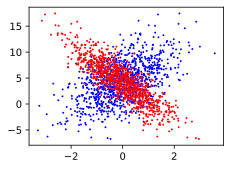

In [14]:
# 可视化
d2l.set_figsize()

# 当我们再训练网络的时候可能希望保持一部分的网络参数不变，只对其中一部分的参数进行调整；
# 或者只训练部分分支网络，并不让其梯度对主网络的梯度造成影响，
# 这时候我们就需要使用detach()函数来切断一些分支的反向传播

# X, y, scale, color
d2l.plt.scatter(features[:, 0].numpy(), labels.numpy(), 1, 'b')
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1, 'r')

## 3.2.2 读取数据集

In [15]:
# 训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 
# 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 
# 该函数能打乱数据集中的样本并以小批量方式获取数据

# 定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 
# 每个小批量包含一组特征和标签

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # shuffle
    random.shuffle(indices)
    # (0, 10), (10, 20)
    for i in range(0, num_examples, batch_size):
        # 索引,tensor格式
        batch_indices = torch.tensor(
            indices[i: min((i + batch_size), num_examples)])
        # tensor 可以按照tensor索引取元素
        yield features[batch_indices], labels[batch_indices]

# yield是暂停函数，return是结束函数； 即yield返回值后继续执行函数体内代码，
# 如果要返回的数据是通过for等循环生成的迭代器类型数据（如列表、元组），return只能在循环外部一次性地返回，
# yeild则可以在循环内部逐个元素返回
# return返回值后不再执行函数体内代码

In [16]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
    
# 上面实现的迭代对教学来说很好，但它的执行效率很低
# 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据

tensor([[ 1.1252,  0.0312],
        [ 0.3907, -0.2705],
        [ 1.2300, -0.4393],
        [-1.2175,  2.5056],
        [-0.5682,  0.0732],
        [ 0.8946, -0.8196],
        [-0.2562,  0.6607],
        [ 0.7807, -0.5171],
        [ 2.2598, -0.5769],
        [ 0.3193,  0.4664]]) 
 tensor([[ 6.2435],
        [ 5.9101],
        [ 8.0737],
        [-6.4639],
        [ 2.7978],
        [ 8.6875],
        [ 1.4712],
        [ 7.4602],
        [10.5441],
        [ 3.1666]])


## 3.2.3 初始化模型参数

In [17]:
# tensor一维向量w只有一个维度
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[0.0267],
         [0.0021]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 3.2.4 定义模型

In [18]:
def linreg(X, w, b): #@save
    return torch.matmul(X, w) + b

## 3.2.5 定义损失函数

In [19]:
def squared_loss(y_hat, y): #@save
    '''平方损失'''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

In [20]:
def sgd(params, lr, batch_size): #@save
    '''小批量随机梯度下降'''
    # 可以让节点不进行求梯度，从而节省了内存控件
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练

In [21]:
# 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 
# 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。
lr = 0.01
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    # 小批量数据
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X,y的小批量损失,l是关于w,b的式子
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss {float(train_l.mean()):.5f}')

epoch1, loss 2.17181
epoch2, loss 0.28461
epoch3, loss 0.04073
epoch4, loss 0.00929
epoch5, loss 0.00525


In [22]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([ 0.0165, -0.0212], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0247], grad_fn=<RsubBackward1>)


In [23]:
# 学习了深度网络是如何实现和优化的。
# 在这一过程中只（1）通过张量来进行数据存储和线性代数；（2）通过自动微分来计算梯度，不需要定义层或复杂的优化器。

# 3.3 线性回归的简洁实现

## 3.3.1 生成数据集

In [24]:
from torch.utils import data

true_w = torch.tensor([2.0, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features[0], labels[0]

(tensor([-2.0994, -2.0694]), tensor([7.0618]))

## 3.3.2 读取数据集

In [25]:
# 可以调用框架中现有的API来读取数据, 布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据
def load_array(data_arrays, batch_size, is_train=True): #@save
    '''构造pytorch数据迭代器'''
    # 可以使用星号作为可迭代项的前缀来解包它们的元素
    # *运算符用于迭代的取出list中的内容
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array([features, labels], batch_size)

In [26]:
next(iter(data_iter))

[tensor([[-0.7001, -0.1921],
         [-0.0359,  0.9456],
         [ 0.6489, -0.5532],
         [ 0.2760, -1.6746],
         [ 0.8610, -0.8476],
         [ 1.9759,  0.3153],
         [-0.8611,  1.1516],
         [-0.4604, -0.4353],
         [-0.1456, -0.5773],
         [ 0.1822,  1.6525]]),
 tensor([[ 3.5822],
         [ 0.6434],
         [ 7.4967],
         [10.4317],
         [ 8.8773],
         [ 7.0173],
         [-1.3613],
         [ 4.8890],
         [ 5.8954],
         [-1.0312]])]

## 3.3.3 定义模型

In [27]:
# 对于标准深度学习模型，我们可以使用框架的预定义好的层。
# 这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。
# 首先定义一个模型变量net，它是一个Sequential类的实例。 Sequential类将多个层串联在一起。

# 在PyTorch中，全连接层在Linear类中定义。
# 将两个参数传递到nn.Linear中。 第一个指定输入特征形状，即2，
# 第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [28]:
# nn为神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

## 3.3.4 初始化模型参数

In [29]:
# 深度学习框架通常有预定义的方法来初始化参数。 
# 在这里，指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样， 偏置参数将初始化为零。
# 正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。 
# 通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。

In [30]:
net[0].weight.data.normal_(0, 0.01),net[0].bias.data.fill_(0)

(tensor([[-0.0054,  0.0144]]), tensor([0.]))

## 3.3.5 定义损失函数

In [31]:
# 计算均方误差使用的是MSELoss类，也称为平方范数。 默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

## 3.3.6 定义优化算法

In [32]:
# 小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。 
# 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）
# 以及优化算法所需的超参数字典。 
# 小批量随机梯度下降只需要设置lr值，这里设置为0.03。

# 通过调用net(X)生成预测并计算损失l（前向传播）
# 通过进行反向传播来计算梯度
# 通过调用优化器来更新模型参数

In [33]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 3.3.7 训练

In [34]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) # 返回样本损失的平均值
        trainer.zero_grad()
        l.backward() # 一个batch的平均损失
        trainer.step() # 更新参数，不需要除以batch_size
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss {l:.5f}')

epoch1, loss 0.01067
epoch2, loss 0.01017
epoch3, loss 0.01009
epoch4, loss 0.01022
epoch5, loss 0.01009


In [35]:
w = net[0].weight.data
b = net[0].bias.data
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([0.0007, 0.0060])
b的估计误差:tensor([0.0047])


In [36]:
# 我们可以使用PyTorch的高级API更简洁地实现模型
# 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数
# 我们可以通过_结尾的方法将参数替换，从而初始化参数。

In [37]:
# Q
# 如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？
lr * batch_size

# 如何访问线性回归的梯度？
net[0].weight.grad, net[0].bias.grad

(tensor([[ 0.1018, -0.0424]]), tensor([0.0684]))